In [1]:
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import geoplot as gplt
import numpy as np
import urllib
import shutil
import zipfile
import os
import re
import geopandas as gpd
import contextily as ctx

In [2]:
df = pd.read_csv('sf-crime/train/train.csv', parse_dates=['Dates'])
df = df.dropna()

In [3]:
df

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541
...,...,...,...,...,...,...,...,...,...
878044,2003-01-06 00:15:00,ROBBERY,ROBBERY ON THE STREET WITH A GUN,Monday,TARAVAL,NONE,FARALLONES ST / CAPITOL AV,-122.459033,37.714056
878045,2003-01-06 00:01:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Monday,INGLESIDE,NONE,600 Block of EDNA ST,-122.447364,37.731948
878046,2003-01-06 00:01:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Monday,SOUTHERN,NONE,5TH ST / FOLSOM ST,-122.403390,37.780266
878047,2003-01-06 00:01:00,VANDALISM,"MALICIOUS MISCHIEF, VANDALISM OF VEHICLES",Monday,SOUTHERN,NONE,TOWNSEND ST / 2ND ST,-122.390531,37.780607


In [30]:
Crime_Categories = df["Category"].unique()
Crime_Categories

array(['WARRANTS', 'OTHER OFFENSES', 'LARCENY/THEFT', 'VEHICLE THEFT',
       'VANDALISM', 'NON-CRIMINAL', 'ROBBERY', 'ASSAULT', 'WEAPON LAWS',
       'BURGLARY', 'SUSPICIOUS OCC', 'DRUNKENNESS',
       'FORGERY/COUNTERFEITING', 'DRUG/NARCOTIC', 'STOLEN PROPERTY',
       'SECONDARY CODES', 'TRESPASS', 'MISSING PERSON', 'FRAUD',
       'KIDNAPPING', 'RUNAWAY', 'DRIVING UNDER THE INFLUENCE',
       'SEX OFFENSES FORCIBLE', 'PROSTITUTION', 'DISORDERLY CONDUCT',
       'ARSON', 'FAMILY OFFENSES', 'LIQUOR LAWS', 'BRIBERY',
       'EMBEZZLEMENT', 'SUICIDE', 'LOITERING',
       'SEX OFFENSES NON FORCIBLE', 'EXTORTION', 'GAMBLING', 'BAD CHECKS',
       'TREA', 'RECOVERED VEHICLE', 'PORNOGRAPHY/OBSCENE MAT'],
      dtype=object)

In [7]:
#which crimes are higher in the city

In [8]:
number_of_crimes = df.Category.value_counts()


print("The following categories :")
print(number_of_crimes[0:8].index)
print("make up to " + str(sum(number_of_crimes[0:8])/sum(number_of_crimes))
      + " percent of the crimes")

The following categories :
Index(['LARCENY/THEFT', 'OTHER OFFENSES', 'NON-CRIMINAL', 'ASSAULT',
       'DRUG/NARCOTIC', 'VEHICLE THEFT', 'VANDALISM', 'WARRANTS'],
      dtype='object')
make up to 0.7573073940064848 percent of the crimes


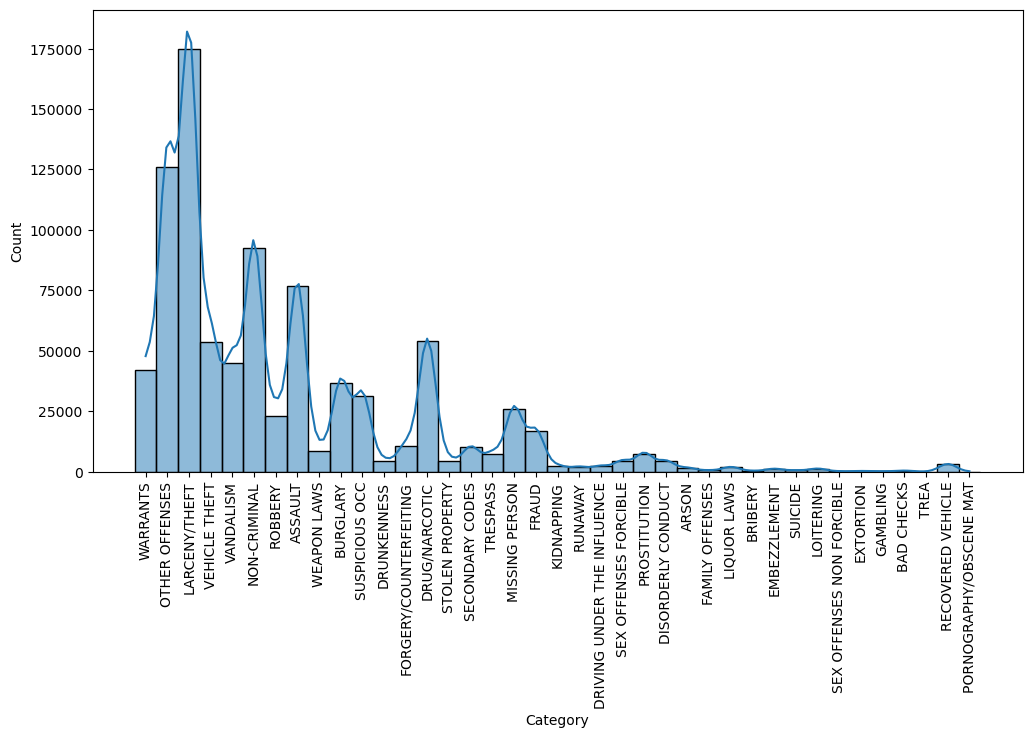

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
sns.histplot(x='Category', data=df, kde=True, ax=ax)
ax.tick_params(axis='x', rotation=90)

<AxesSubplot:xlabel='DayOfWeek'>

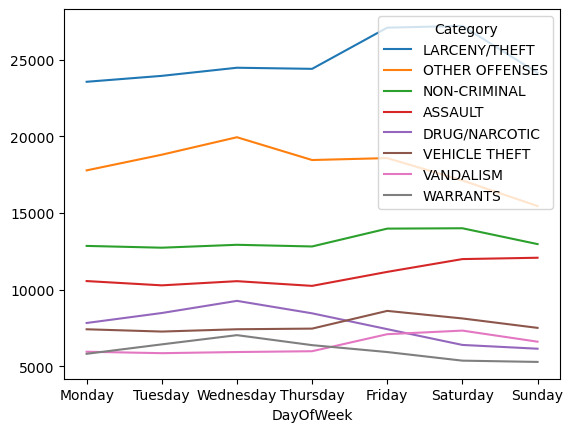

In [11]:
main_crime_categories = list(number_of_crimes[0:8].index)
tmp = df.loc[:,["DayOfWeek","Category"]]
pt = pd.pivot_table(tmp,index="DayOfWeek",columns="Category",aggfunc=len,fill_value=0)
pt.loc[["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"],main_crime_categories].plot()

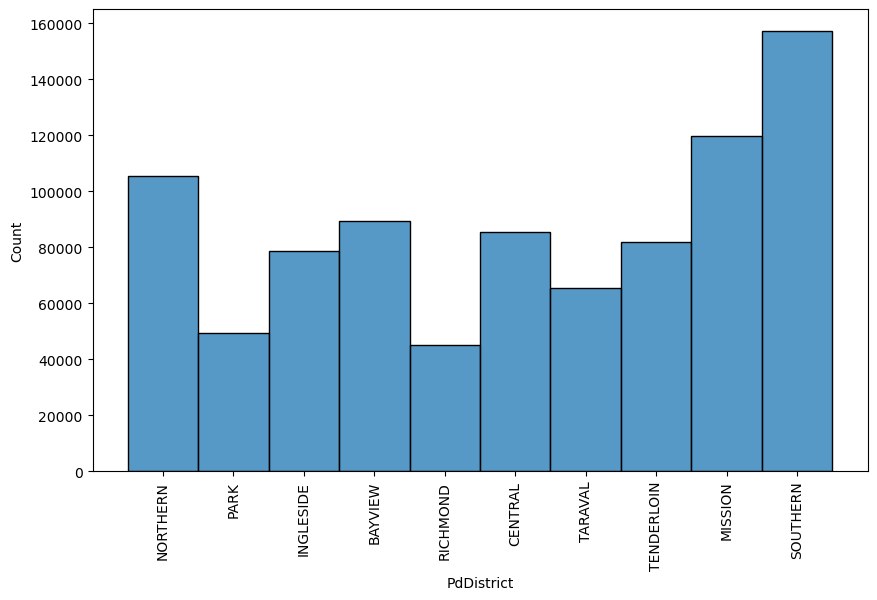

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
sns.histplot(x='PdDistrict', data=df, ax=ax)
ax.tick_params(axis='x', rotation=90)

Text(0.5, 1.0, 'Number of top 12 crimes per District')

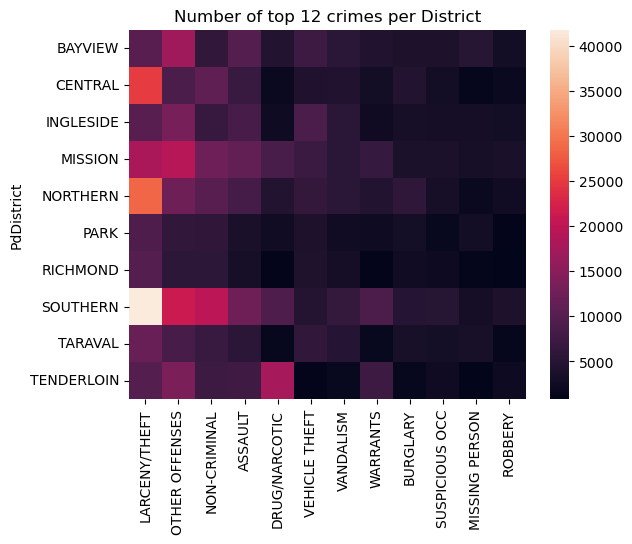

In [39]:
pt = pd.pivot_table(df,index="PdDistrict",columns="Category",aggfunc=len,fill_value=0)["Dates"]
_ = pt.loc[:,number_of_crimes[0:12].index]
ax = sns.heatmap(_)
ax.set_title("Number of top 12 crimes per District")

Text(0.5, 1.0, 'Share of each crime in each district')

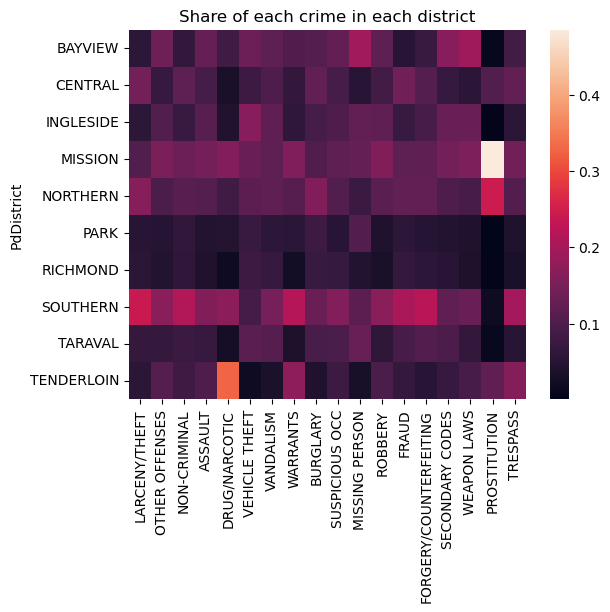

In [47]:
pt = pd.pivot_table(df,index="PdDistrict",columns="Category",aggfunc=len,fill_value=0)["Dates"]
pt = pt/pt.sum(axis = 0)
_ = pt.loc[:,number_of_crimes[0:18].index]
ax = sns.heatmap(_)
ax.set_title("Share of each crime in each district")

In [49]:
def correct_coordinates(district):
    tmp = df[df["PdDistrict"] == district]
    x_avg = tmp.X.mean()
    y_avg = tmp.Y.mean()
    return([x_avg,y_avg])

index_to_correct = df[(df["X"] > -121)|(df["Y"] > 50)].index

for i in index_to_correct:
    tmp = correct_coordinates(df.loc[i,"PdDistrict"])
    x = tmp[0]
    y = tmp[1]
    df.loc[i,"X"] = x 
    df.loc[i,"Y"] = y

<AxesSubplot:xlabel='X', ylabel='Y'>

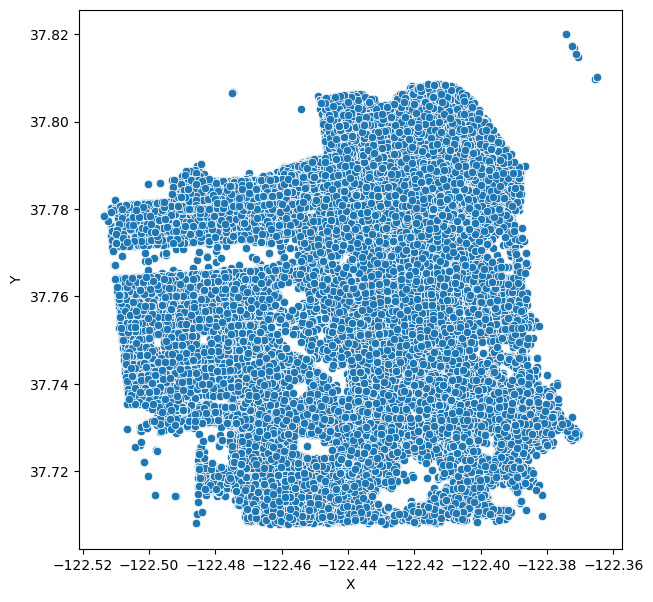

In [73]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
sns.scatterplot(data=df, x='X', y='Y')
# plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')

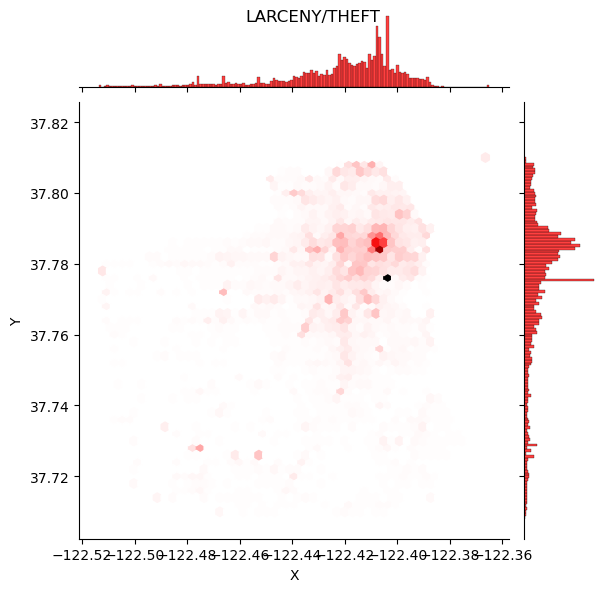

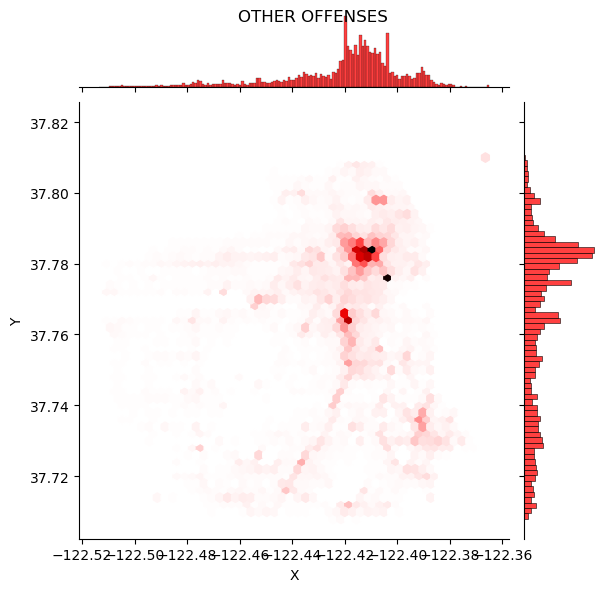

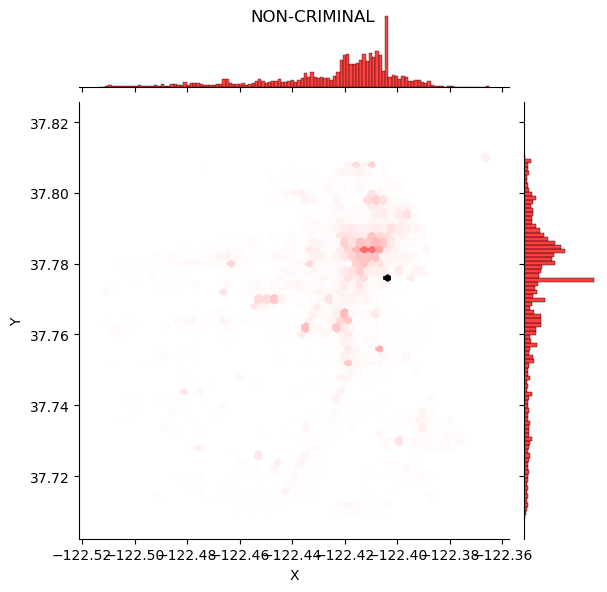

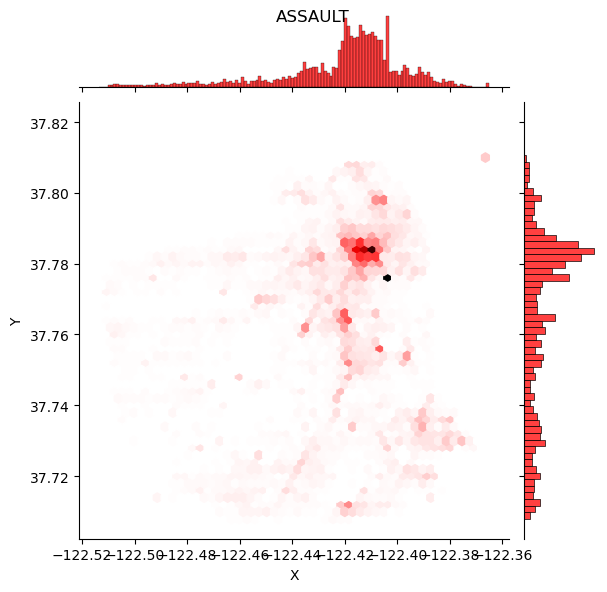

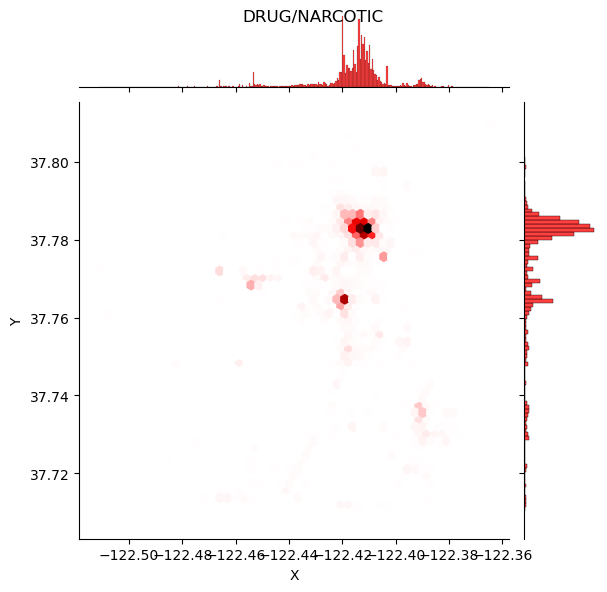

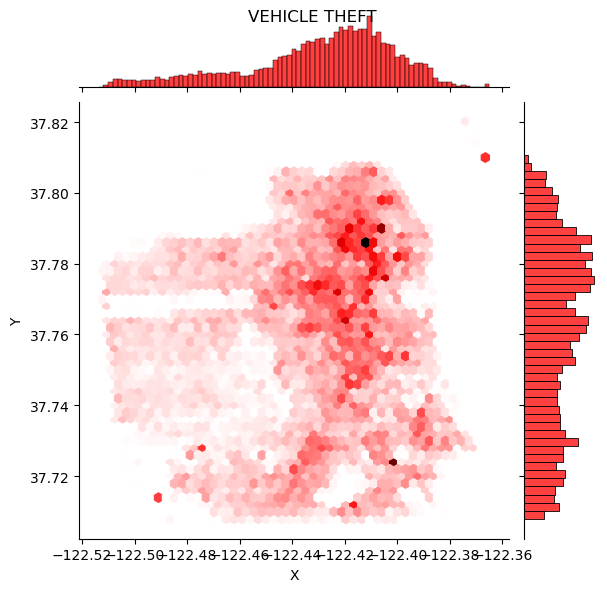

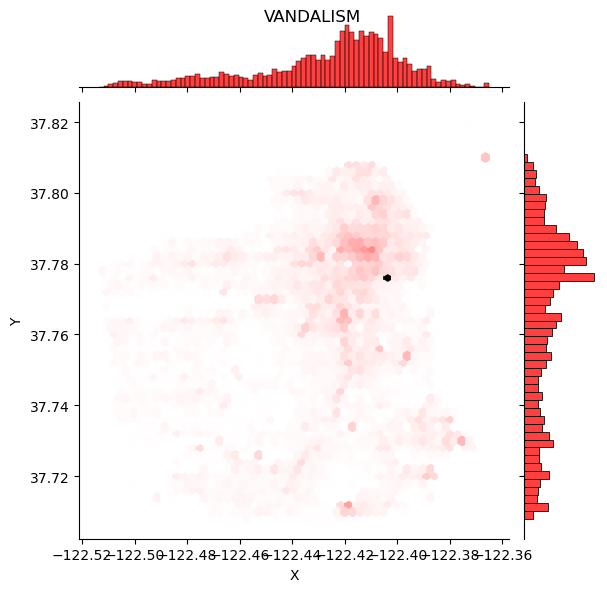

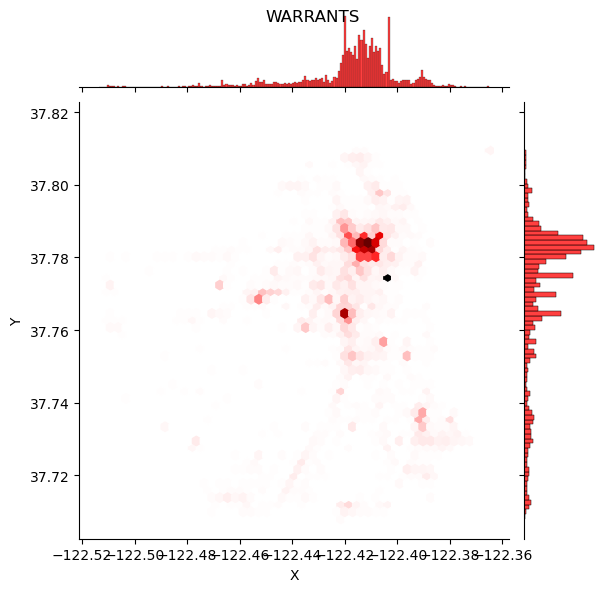

In [68]:
for c in number_of_crimes[0:8].index:
    df_tmp = df.loc[df.Category == c,["X","Y"]]
    sns.jointplot(x=df_tmp["X"] , y=df_tmp["Y"],kind="hex", color="r").fig.suptitle(c)

In [42]:
#number of incidents per day
number_of_crimes

LARCENY/THEFT                  174900
OTHER OFFENSES                 126182
NON-CRIMINAL                    92304
ASSAULT                         76876
DRUG/NARCOTIC                   53971
VEHICLE THEFT                   53781
VANDALISM                       44725
WARRANTS                        42214
BURGLARY                        36755
SUSPICIOUS OCC                  31414
MISSING PERSON                  25989
ROBBERY                         23000
FRAUD                           16679
FORGERY/COUNTERFEITING          10609
SECONDARY CODES                  9985
WEAPON LAWS                      8555
PROSTITUTION                     7484
TRESPASS                         7326
STOLEN PROPERTY                  4540
SEX OFFENSES FORCIBLE            4388
DISORDERLY CONDUCT               4320
DRUNKENNESS                      4280
RECOVERED VEHICLE                3138
KIDNAPPING                       2341
DRIVING UNDER THE INFLUENCE      2268
RUNAWAY                          1946
LIQUOR LAWS 

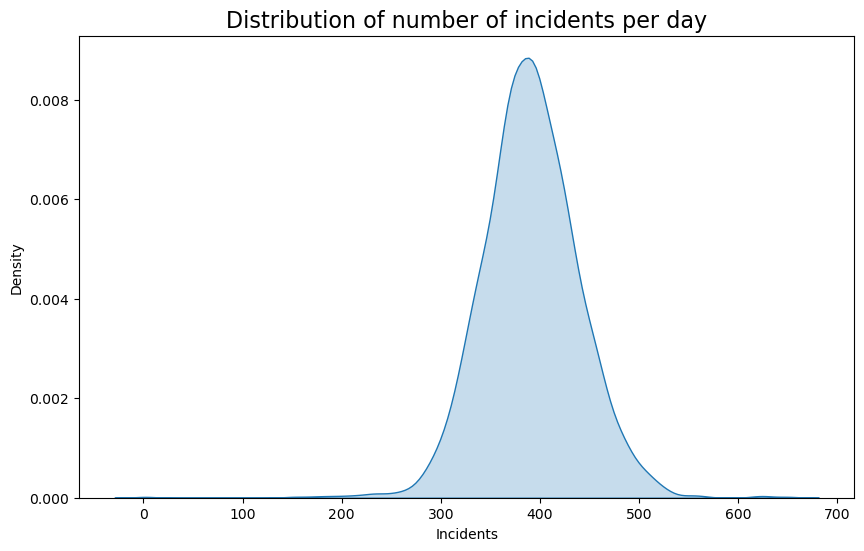

In [97]:
col = sns.color_palette()

df['Date'] = df.Dates.dt.date

plt.figure(figsize=(10, 6))
data = df.groupby('Date').count().iloc[:, 0]
sns.kdeplot(data=data, fill=True)
plt.title(
    'Distribution of number of incidents per day', fontdict={'fontsize': 16})
plt.xlabel('Incidents')
plt.ylabel('Density')
plt.show()

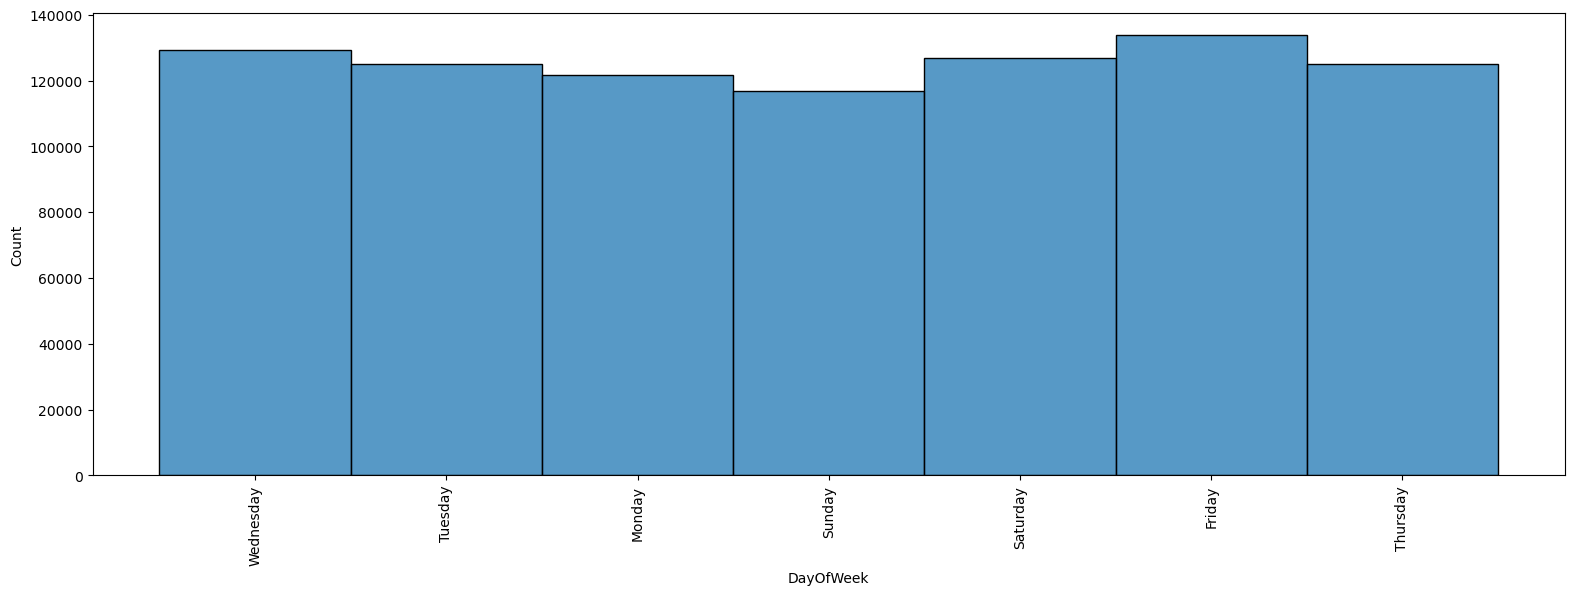

In [112]:
fig, ax = plt.subplots(1, 1, figsize=(19, 6))
sns.histplot(x='DayOfWeek', data=df, ax=ax)
ax.tick_params(axis='x', rotation=90)

In [114]:
#Which incidents are most frequently dealt with by each police station?

In [115]:
cross_tab_train = pd.crosstab(df['Category'], df['PdDistrict'])
cross_tab_train.style.background_gradient()

PdDistrict,BAYVIEW,CENTRAL,INGLESIDE,MISSION,NORTHERN,PARK,RICHMOND,SOUTHERN,TARAVAL,TENDERLOIN
Category,,,,,,,,,,
ARSON,393,111,182,145,149,65,103,185,120,60
ASSAULT,9857,6977,8533,11149,8318,3515,3202,12183,5463,7679
BAD CHECKS,34,65,32,46,54,15,31,74,36,19
BRIBERY,56,12,53,66,18,7,8,37,17,15
BURGLARY,3930,4519,3331,3745,5854,2888,2696,4841,3463,1488
DISORDERLY CONDUCT,219,494,171,1099,452,271,108,511,162,833
DRIVING UNDER THE INFLUENCE,179,160,206,357,260,176,319,306,202,103
DRUG/NARCOTIC,4498,1805,2373,8757,4511,2573,999,9228,1531,17696
DRUNKENNESS,243,517,190,782,368,374,149,959,259,439
